In [26]:
import os
import os.path as op
import pyplr as plr
import matplotlib.pyplot as plt
from pandas import HDFStore
import seaborn as sns
import pandas as pd
#from based_noise_blinks_detection import based_noise_blinks_detection
sns.set_context(context="paper", font_scale=2.1)

In [22]:
# directories for analysis
expdir = r"C:\Users\engs2242\Documents\cvd_pupillometry\data\red_vs_blue_2s_pulse_3trials_each"
subjdirs = [op.join(expdir,s) for s in os.listdir(expdir) if s.startswith("sub")]
subjdir = subjdirs[4]

# columns to load and analyse
load_cols =  ["pupil_timestamp","diameter","diameter_3d"]
pupil_cols = ["diameter","diameter_3d"]

# some parameters
sample_rate = 120
duration = 7600
onset = 600

# Example processing for single subject

## Load data, interpolate zeros and blinks, smooth and plot

************************************************************
***************************sub005***************************
************************************************************
Loaded 54163 samples
Loaded 12 events
41 blinks detected by Pupil Labs, average duration 0.302 s
1509 samples (2.786 %) reconstructed with linear interpolation


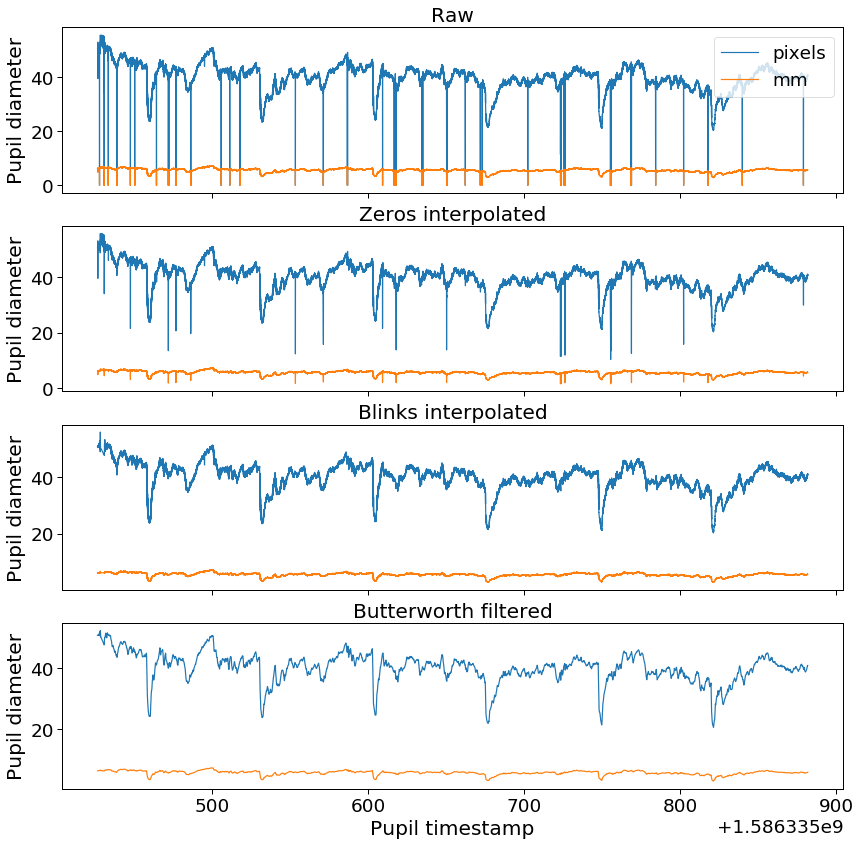

In [16]:
# initialize subject analysis
subjid, pl_data_dir, out_dir = plr.init_subject_analysis(subjdir, out_dir_nm="analysis")

# load data - can use Pupil Labs blink detector or the Hershman algorithm
samples = plr.load_pupil(pl_data_dir, cols=load_cols)
events  = plr.load_annotations(pl_data_dir)
blinks  = plr.load_blinks(pl_data_dir)
#blinks = based_noise_blinks_detection(samples["diameter"], sample_rate)

# make figure for processing
f, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14,14))

# plot the raw data
samples[pupil_cols].plot(title="Raw", ax=axs[0], legend=False)

# interpolate zeros
samples = plr.interpolate_zeros(samples, fields=pupil_cols)
samples[pupil_cols].plot(title="Zeros interpolated", ax=axs[1], legend=False)

# interpolate blinks
samples = plr.interpolate_blinks(samples, blinks, fields=pupil_cols)
samples[pupil_cols].plot(title="Blinks interpolated", ax=axs[2], legend=False)

# smooth  
#samples = plr.savgol_series(samples, fields=pupil_cols, window_length=51, filt_order=7)
samples = plr.butterworth_series(samples, fields=pupil_cols, filt_order=3, cutoff_freq=.05)
samples[pupil_cols].plot(title="Butterworth filtered", ax=axs[3], legend=False)

for ax in axs:
    ax.set_ylabel("Pupil diameter")    
    ax.set_xlabel("Pupil timestamp")
axs[0].legend(loc="upper right", labels=["pixels","mm"])

## Event extraction, baseline-correction, trial rejection and plot

Extracted ranges for 6 events
Extracted ranges for 6 events
Percentage of data interpolated for each trial (mean = 2.21): 
        interpolated
event              
0          2.394737
1          1.197368
2          3.000000
3          2.855263
4          2.921053
5          0.907895


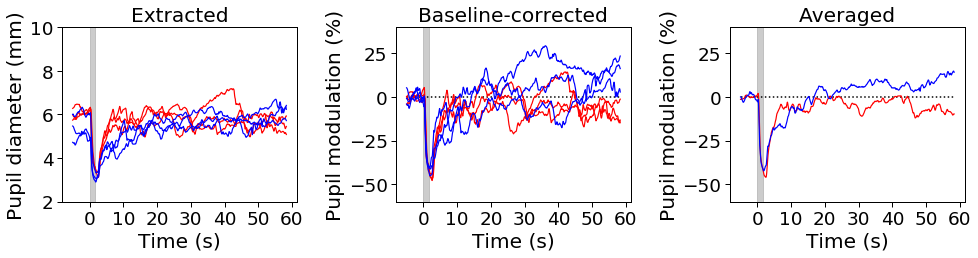

In [33]:
events = events.query("label=='light_on'")
events.index = events["timestamp"]

# extract the events and their baselines
ranges = plr.extract(samples, events, offset=-onset, duration=duration, 
                     borrow_attributes=["color"])
baselines = plr.extract(samples, events, offset=-onset, duration=onset,
                        borrow_attributes=["color"]).mean(level=0)


# new columns for baseline normalised data
ranges["diameter_pc"] = (ranges.diameter / baselines.diameter - 1).values * 100
ranges["diameter_3dpc"] = (ranges.diameter_3d / baselines.diameter_3d - 1).values * 100

# drop / markup bad trials
ranges = plr.reject_bad_trials(ranges, interp_thresh=20, drop=False)

# calculate averages for conditions
averages = ranges.reset_index().groupby(by=["color","onset"], as_index=True).mean()

# make figure for extraction, baseline-correction and averaging
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4))

# plot extracted trials
ranges.reset_index(inplace=True)
sns.lineplot(x="onset", y="diameter_3d", data=ranges, units="event", 
             hue="color", estimator=None, palette=["red","blue"],
             ax=axs[0], legend=False)
axs[0].set_ylabel("Pupil diameter (mm)")
axs[0].set_ylim((2,10))

axs[0].set_title("Extracted")

# plot baseline corrected trials
sns.lineplot(x="onset", y="diameter_3dpc", data=ranges, units="event", 
         hue="color", estimator=None,palette=["red","blue"],
         ax=axs[1], legend=False)
axs[1].set_title("Baseline-corrected")

# plot averages
axs[2].plot(averages.loc['red', "diameter_3dpc"], color='red')
axs[2].plot(averages.loc['blue', "diameter_3dpc"], color='blue')
axs[2].set_title("Averaged")

for ax in axs:
    ax.set_xlabel("Time (s)")
    ax.set_xticks(range(600, 8400, 1200))
    ax.set_xticklabels([str(xtl) for xtl in range(0,65,10)])
    ax.axvspan(600,800,0,1,color='k', alpha=.2) 

for ax in axs[1:]:
    ax.set_ylabel("Pupil modulation (%)") 
    ax.hlines(0, 0, 7600, color='k', ls=':', lw=1.5)
    ax.set_ylim((-60,40))

f.tight_layout()

## Calculate metrics from averages for each condition

In [35]:
# latency to 5% constriction
pc = .05

# aggregate
metrics = averages.groupby(level=0).agg(
    B   = ("diameter_3d", lambda s: plr.baseline(s, onset)),
    L   = ("diameter_3d", lambda s: plr.latency_to_constriction(s, sample_rate, onset, pc)),
    PC  = ("diameter_3d", lambda s: plr.peak_constriction(s, onset)),
    MCA = ("diameter_3d", lambda s: plr.maximum_constriction_amplitude(s, onset)),
    MCT = ("diameter_3d", lambda s: plr.time_to_peak_constriction(s, sample_rate, onset)),
    CT  = ("diameter_3d", lambda s: plr.constriction_time(s, sample_rate, onset, pc)),
    MCV = ("diameter_3d", lambda s: plr.maximum_constriction_velocity(s, sample_rate))
    )
metrics

,B,L,PC,MCA,MCT,CT,MCV
color,,,,,,,
blue,5.389503,358.333333,3.095354,2.294149,1891.666667,1533.333333,1.889508
red,6.079200,466.666667,3.276623,2.802578,2516.666667,2050.000000,1.866300


## Load all processed data and combine

In [28]:
store = expdir + "\\processed.h5"

# loop on subjects
combined = pd.DataFrame()
for subjdir in subjdirs:
    subject = subjdir[-6:]
    ranges = pd.read_hdf(store, key=subject)
    ranges["subject"] = subject
    combined = combined.append(ranges)

combined.reset_index(inplace=True)

## Plot subject and grand averages

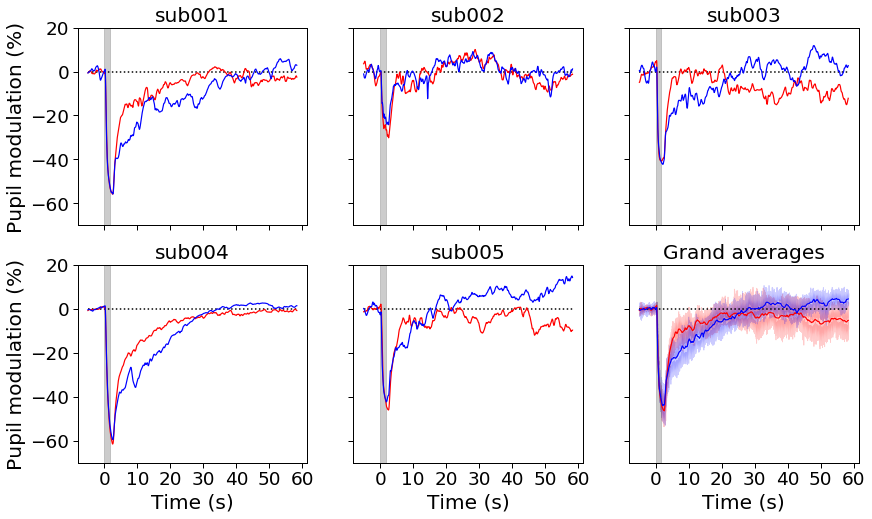

In [40]:
# plot grand averages    
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(14,8))
axs = [item for sublist in axs for item in sublist]
p = 0
for sub, df in combined.groupby('subject'):
    averages = df.groupby(by=["color","onset"], as_index=True).mean()

    axs[p].plot(averages.loc['red', "diameter_3dpc"], color='red')
    axs[p].plot(averages.loc['blue', "diameter_3dpc"], color='blue')
    axs[p].set_title(sub)
    p+=1
sns.lineplot(x="onset", y="diameter_3dpc", hue='color', data=combined,
             n_boot=10, ci=95, palette=['red','blue'], ax=axs[p], legend=False)

for ax in axs[3:]:
    ax.set_xlabel("Time (s)")
    
for ax in [axs[0], axs[3]]:
    ax.set_ylabel("Pupil modulation (%)")

for ax in axs:
    ax.set_xticks(range(600, 8400, 1200))
    ax.set_xticklabels([str(xtl) for xtl in range(0,65,10)])
    ax.axvspan(600,800,0,1,color='k', alpha=.2) 
    ax.hlines(0, 0, 7600, color='k', ls=':', lw=1.5)
    ax.set_ylim((-70,20))
axs[-1].set_title("Grand averages");